In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from transformers import RobertaTokenizer, RobertaModel
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
import contractions as ct
import re
from tqdm.auto import tqdm
from sklearn.metrics import f1_score, classification_report, hamming_loss

In [2]:
raw_df1 = pd.read_csv("data/full_dataset/goemotions_1.csv")
raw_df2 = pd.read_csv("data/full_dataset/goemotions_2.csv")
raw_df3 = pd.read_csv("data/full_dataset/goemotions_3.csv")

In [3]:
raw_df1.shape, raw_df2.shape, raw_df3.shape 

((70000, 37), (70000, 37), (71225, 37))

In [4]:
raw_df1.sample(5)

,text,id,author,subreddit,link_id,parent_id,created_utc,rater_id,example_very_unclear,admiration,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
37261,So now disabled people don’t have rights . You...,edo5i2h,CDfm,ireland,t3_ae5w0m,t1_edo3w94,1.547075e+09,56,False,0,...,0,0,0,0,0,0,0,0,0,0
63474,Didn't he say [NAME] should cave and give [NAM...,eefj876,Like1OngoingOrgasm,PoliticalHumor,t3_ahjrcb,t3_ahjrcb,1.547897e+09,49,False,0,...,0,0,0,0,0,0,0,0,0,1
30646,My cockatiel is sitting on my knee. I gave him...,edoqh4o,Ninjamin_King,Whatcouldgowrong,t3_ae8fna,t1_edo5im9,1.547092e+09,9,False,0,...,1,0,0,0,0,0,0,0,0,0
699,You need medical help.,eeo7r7a,Zaydh,confession,t3_aijdbq,t3_aijdbq,1.548134e+09,7,False,0,...,0,0,0,0,0,0,0,0,0,0
15816,Exactly what I came here to write lol,ee4wxvq,-Puddintane-,exchristian,t3_agacg5,t1_ee4o0m9,1.547576e+09,59,False,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
raw_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 37 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   text                  70000 non-null  object 
 1   id                    70000 non-null  object 
 2   author                70000 non-null  object 
 3   subreddit             70000 non-null  object 
 4   link_id               70000 non-null  object 
 5   parent_id             70000 non-null  object 
 6   created_utc           70000 non-null  float64
 7   rater_id              70000 non-null  int64  
 8   example_very_unclear  70000 non-null  bool   
 9   admiration            70000 non-null  int64  
 10  amusement             70000 non-null  int64  
 11  anger                 70000 non-null  int64  
 12  annoyance             70000 non-null  int64  
 13  approval              70000 non-null  int64  
 14  caring                70000 non-null  int64  
 15  confusion          

In [6]:
raw_df = pd.concat([raw_df1,raw_df2,raw_df3])
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 211225 entries, 0 to 71224
Data columns (total 37 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   text                  211225 non-null  object 
 1   id                    211225 non-null  object 
 2   author                211225 non-null  object 
 3   subreddit             211225 non-null  object 
 4   link_id               211225 non-null  object 
 5   parent_id             211225 non-null  object 
 6   created_utc           211225 non-null  float64
 7   rater_id              211225 non-null  int64  
 8   example_very_unclear  211225 non-null  bool   
 9   admiration            211225 non-null  int64  
 10  amusement             211225 non-null  int64  
 11  anger                 211225 non-null  int64  
 12  annoyance             211225 non-null  int64  
 13  approval              211225 non-null  int64  
 14  caring                211225 non-null  int64  
 15  confus

In [7]:
raw_df.shape

(211225, 37)

In [8]:
emotion_columns = raw_df.columns[9:]
grouped_df = raw_df.groupby(['id', 'text'])[emotion_columns].sum().reset_index()

In [9]:
grouped_df.shape

(58011, 30)

In [10]:
for col in emotion_columns:
    grouped_df[col] = (grouped_df[col] > 0).astype(int)

master_df = grouped_df.drop(columns=['id'])

In [11]:
master_df.shape

(58011, 29)

In [12]:
class_counts = master_df[emotion_columns].sum().astype(int)
class_counts = class_counts.sort_values(ascending=False)

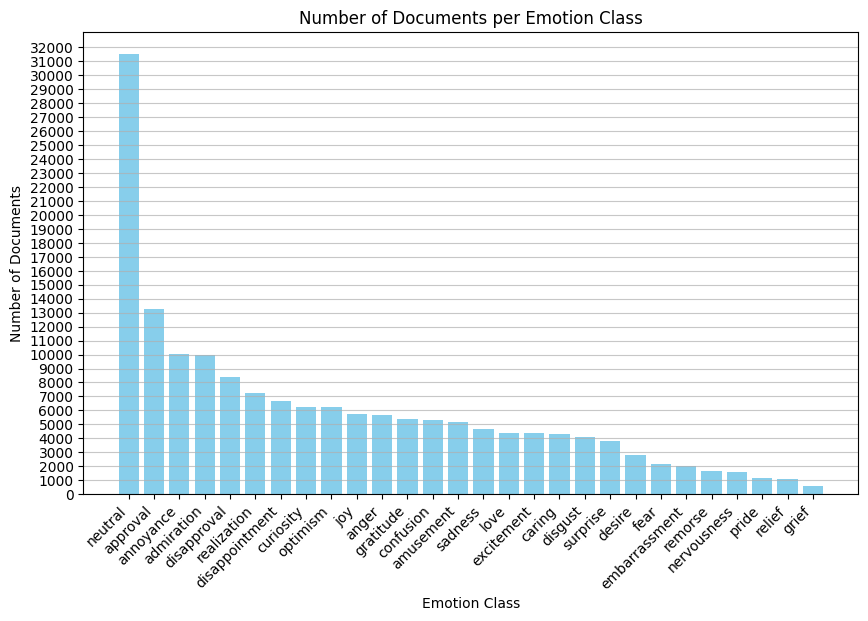

In [13]:
plt.figure(figsize=(10,6))
plt.bar(class_counts.index, class_counts.values, color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.yticks(np.arange(0, class_counts.max() + 500, 1000))
plt.xlabel("Emotion Class")
plt.ylabel("Number of Documents")
plt.title("Number of Documents per Emotion Class")
plt.grid(axis='y', linestyle='-', alpha=0.7)

In [14]:
df = master_df[master_df['neutral']==0].copy()
df = df.drop(columns=['neutral'])

In [15]:
df.shape

(26488, 28)

In [16]:
df.head()

,text,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,...,joy,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise
0,Fast as [NAME] will carry me. Seriously uptown...,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,TL;DR No more Superbowls for [NAME]. Get ready...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,So much time saved. Not.,0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
6,Thanks for the advice man ! Have a great New Y...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,Glad to hear it. You deserve your best life wi...,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0


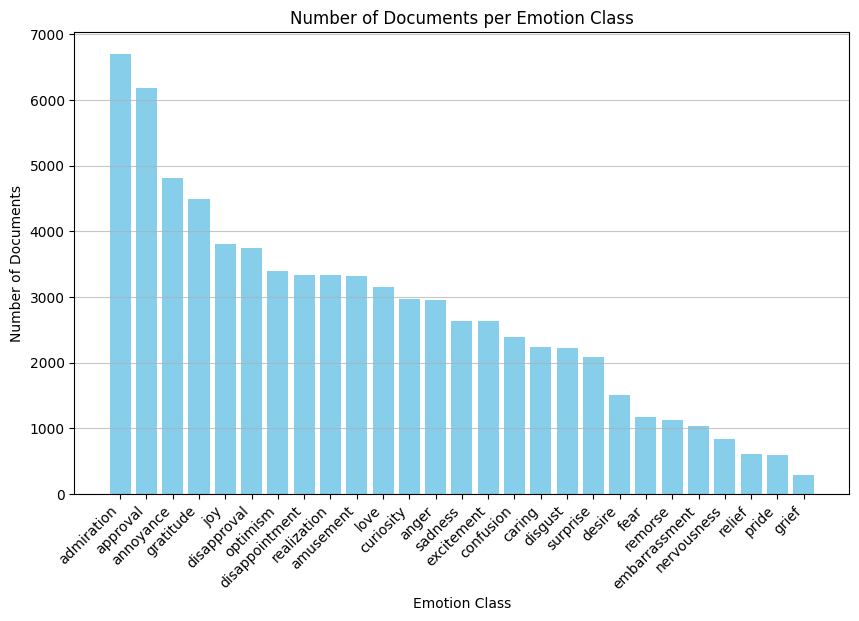

In [17]:
class_counts = df.iloc[:,1:].sum().astype(int)
class_counts = class_counts.sort_values(ascending=False)

plt.figure(figsize=(10,6))
plt.bar(class_counts.index, class_counts.values, color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.yticks(np.arange(0, class_counts.max() + 500, 1000))
plt.xlabel("Emotion Class")
plt.ylabel("Number of Documents")
plt.title("Number of Documents per Emotion Class")
plt.grid(axis='y', linestyle='-', alpha=0.7)

In [26]:
X = df["text"]
y = df.iloc[:,1:]

In [27]:
def clean_text(text):
    # lowercase text
    text = text.lower()
    # remove text that are inside brackets eg: [NAME], [RELIGION]
    text = re.sub(r'\[.*?\]', '', text)
    # remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # remove technical punctuation characters like ""#$%&\'()*+,-./:;<=>@\\^_`{|}~"
    technical_punct = '"#$%&\'()*+,-./:;<=>@\\^_`{|}~'
    text = text.translate(str.maketrans(technical_punct, ' ' * len(technical_punct)))
    # remove white spaces
    text = " ".join(text.split())
    return text

X=X.apply(clean_text)

In [28]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [29]:
X_train.head()

18920    using that maybe if i guess every outcome i ca...
13528    calm down snowflake comment stalking from a we...
54891                                            source? 😂
46421                                   she better not die
52021    thanks! going to try this the next time i m at...
Name: text, dtype: object

In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [31]:
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
roberta_model = RobertaModel.from_pretrained("roberta-base").to(device)
for param in roberta_model.parameters():
    param.requires_grad = False

for name, param in roberta_model.named_parameters():
    if "layer.10" in name or "layer.11" in name or "pooler" in name:
        param.requires_grad = True

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
class FineTuneRoBERTa(nn.Module):
    def __init__(self, roberta_model, num_labels):
        super().__init__()
        self.roberta = roberta_model
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(768, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        # Use [CLS] token representation for the classification head
        cls_output = outputs.last_hidden_state[:, 0, :]
        logits = self.classifier(self.dropout(cls_output))
        return logits

In [34]:
model = FineTuneRoBERTa(roberta_model, num_labels=y.shape[1]).to(device)

pos_counts = torch.tensor(y_train.values).sum(axis=0)
neg_counts = len(y_train) - pos_counts
pos_weights = (neg_counts / (pos_counts + 1e-5)).to(device)
# Recalculate pos_weights if needed to ensure they are on the correct device
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weights)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

In [38]:
class EmotionDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=64):
        self.texts = texts.tolist()
        self.labels = labels.values
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.float32)
        }

train_dataset = EmotionDataset(X_train, y_train, tokenizer)
val_dataset = EmotionDataset(X_val, y_val, tokenizer)
test_dataset = EmotionDataset(X_test, X_test, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [36]:
from sklearn.metrics import f1_score
from tqdm import tqdm
import torch

epochs = 5 
best_f1 = 0

for epoch in range(epochs):
    # --- Training ---
    model.train()
    total_train_loss = 0
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]")

    for batch in train_pbar:
        optimizer.zero_grad()
        
        # Move inputs to device
        ids = batch['input_ids'].to(device)
        mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        # Forward pass
        logits = model(ids, mask)
        loss = criterion(logits, labels)
        
        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_train_loss += loss.item()
        train_pbar.set_postfix(loss=loss.item())

    # --- Validation ---
    model.eval()
    all_preds, all_labels = [], []
    total_val_loss = 0
    
    with torch.no_grad():
        for batch in val_loader:
            ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            logits = model(ids, mask)
            val_loss = criterion(logits, labels)
            total_val_loss += val_loss.item()
            
            preds = (torch.sigmoid(logits) > 0.5).int()
            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())

    # Metrics
    val_preds = torch.cat(all_preds).numpy()
    val_labels = torch.cat(all_labels).numpy()
    val_f1 = f1_score(val_labels, val_preds, average='micro')
    
    avg_train_loss = total_train_loss / len(train_loader)
    avg_val_loss = total_val_loss / len(val_loader)
    
    print(f"\nEpoch {epoch+1} Summary:")
    print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val F1: {val_f1:.4f}")
    
    # Save the best model
    if val_f1 > best_f1:
        best_f1 = val_f1
        torch.save(model.state_dict(), "fine_tuned_roberta.pt")
        print("New Best Model Saved! \n")

Epoch 1/5 [Train]: 100%|███████████| 663/663 [01:08<00:00,  9.66it/s, loss=1.77]



Epoch 1 Summary:
Train Loss: 1.0312 | Val Loss: 0.8113 | Val F1: 0.4204
⭐ New Best Model Saved!
--------------------------------------------------


Epoch 2/5 [Train]: 100%|██████████| 663/663 [01:08<00:00,  9.68it/s, loss=0.838]



Epoch 2 Summary:
Train Loss: 0.8371 | Val Loss: 0.7681 | Val F1: 0.4539
⭐ New Best Model Saved!
--------------------------------------------------


Epoch 3/5 [Train]: 100%|██████████| 663/663 [01:08<00:00,  9.66it/s, loss=0.473]



Epoch 3 Summary:
Train Loss: 0.7897 | Val Loss: 0.7491 | Val F1: 0.4645
⭐ New Best Model Saved!
--------------------------------------------------


Epoch 4/5 [Train]: 100%|██████████| 663/663 [01:08<00:00,  9.67it/s, loss=0.898]



Epoch 4 Summary:
Train Loss: 0.7624 | Val Loss: 0.7365 | Val F1: 0.4691
⭐ New Best Model Saved!
--------------------------------------------------


Epoch 5/5 [Train]: 100%|██████████| 663/663 [01:08<00:00,  9.67it/s, loss=0.736]



Epoch 5 Summary:
Train Loss: 0.7392 | Val Loss: 0.7466 | Val F1: 0.4729
⭐ New Best Model Saved!
--------------------------------------------------


In [40]:
model.load_state_dict(torch.load("fine_tuned_roberta.pt"))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(val_loader, desc="Evaluating"):
        ids = batch['input_ids'].to(device)
        mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        logits = model(ids, mask)
        
        # Apply sigmoid and threshold
        preds = (torch.sigmoid(logits) > 0.5).int()
        
        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

# Flatten lists into numpy arrays
val_preds_final = torch.cat(all_preds).numpy()
val_labels_final = torch.cat(all_labels).numpy()

# Get emotion names (column names from your 'y' dataframe)
emotion_names = y.columns.tolist()

print("\n--- Detailed Classification Report ---")
print(classification_report(val_labels_final, val_preds_final, target_names=emotion_names, zero_division=0))

h_loss = hamming_loss(val_labels_final, val_preds_final)
print(f"Hamming Loss (lower is better): {h_loss:.4f}")

Evaluating: 100%|███████████████████████████████| 83/83 [00:06<00:00, 13.05it/s]


--- Detailed Classification Report ---
                precision    recall  f1-score   support

    admiration       0.61      0.85      0.71       703
     amusement       0.50      0.86      0.63       322
         anger       0.37      0.87      0.52       272
     annoyance       0.41      0.82      0.55       456
      approval       0.37      0.72      0.48       593
        caring       0.27      0.82      0.40       211
     confusion       0.39      0.82      0.53       273
     curiosity       0.55      0.90      0.68       317
        desire       0.22      0.73      0.34       150
disappointment       0.28      0.83      0.42       334
   disapproval       0.32      0.87      0.47       357
       disgust       0.27      0.86      0.41       216
 embarrassment       0.14      0.87      0.23       104
    excitement       0.29      0.81      0.42       269
          fear       0.25      0.89      0.39       125
     gratitude       0.60      0.84      0.70       449
       

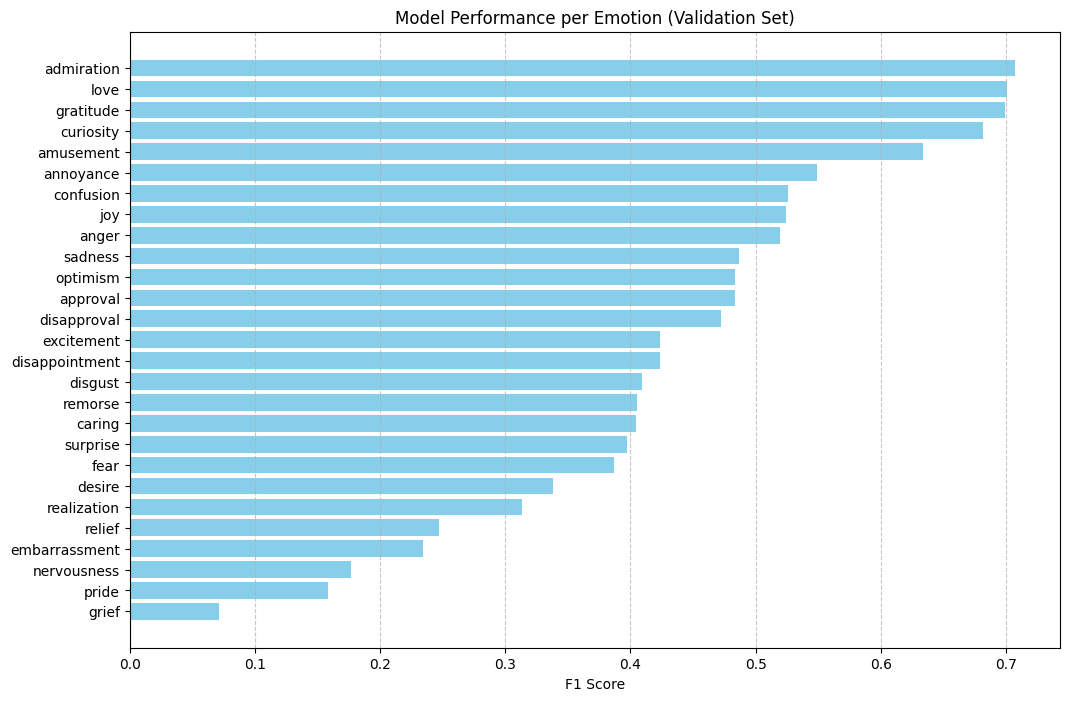

In [41]:
f1_per_class = f1_score(val_labels_final, val_preds_final, average=None)
f1_df = pd.DataFrame({'Emotion': emotion_names, 'F1_Score': f1_per_class})
f1_df = f1_df.sort_values(by='F1_Score', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(f1_df['Emotion'], f1_df['F1_Score'], color='skyblue')
plt.xlabel('F1 Score')
plt.title('Model Performance per Emotion (Validation Set)')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)

In [72]:
def predict_emotion_top_k(text, k=3):
    model.eval()
    
    # 1. Clean and Tokenize
    cleaned_text = clean_text(text)
    inputs = tokenizer(
        cleaned_text, 
        return_tensors="pt", 
        truncation=True, 
        padding='max_length', 
        max_length=256
    ).to(device)
    
    # 2. Forward Pass
    with torch.no_grad():
        logits = model(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'])
        probs = torch.sigmoid(logits).cpu().numpy()[0]
    
    top_k_indices = np.argsort(probs)[-k:][::-1] 
    
    results = []
    for idx in top_k_indices:
        results.append((emotion_names[idx], probs[idx]))
        
    return results

test_sentence = """
Today started off quite slow. I woke up feeling a bit sluggish and unmotivated, almost a sense of dread for the meetings ahead. However, during the lunch break, I had a great conversation with a colleague which turned my mood around completely—I felt a sudden burst of joy and felt much more connected to the team. By the afternoon, though, I ran into a technical bug that was incredibly frustrating. I felt a lot of self-doubt for a while. Now that I’m home, I’m trying to practice some gratitude for the small wins, even if the day wasn't perfect. I’m feeling calmer now, though still a bit pensive about tomorrow.
"""
predictions = predict_emotion_top_k(test_sentence)

print(f"Top {k_value} Emotions for the Journal Entry:")
for emotion, score in predictions:
    print(f"- {emotion}: {score:.4f}")

Top 7 Emotions for the Journal Entry:
- nervousness: 0.9812
- fear: 0.9467
- relief: 0.9454
